<a href="https://colab.research.google.com/github/AlexDuchnowski/logo-gen/blob/main/logo_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Clustering

### Import and Mount

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import tensorflow as tf
import numpy as np
import random
import heapq as hq
import h5py

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Kmeans

In [ ]:
class Kmeans(object):
    """
    K-Means Classifier via Iterative Improvement

    @attrs:
        k: The number of clusters to form as well as the number of centroids to
           generate (default = 10), an int
        tol: Value specifying our convergence criterion. If the ratio of the
             distance each centroid moves to the previous position of the centroid
             is less than this value, then we declare convergence.
        max_iter: the maximum number of times the algorithm can iterate trying
                  to optimize the centroid values, an int,
                  the default value is set to 500 iterations
        centroids: a Numpy array where each element is one of the k cluster centers
    """

    def __init__(self, num_clusters = 16, max_iter = 2000, threshold = 1e-7):
        """
        Initiate K-Means with some parameters
        """
        self.k = num_clusters
        self.tol = threshold
        self.max_iter = max_iter
        self.centroids = None

    def train(self, X):
        """
        Compute K-Means clustering on each class label and store your result in self.cluster_centers_
        :param X: inputs of training data, a 2D Numpy array
        """
        curr_centroids = np.array(random.sample(X.tolist(), self.k))
        prev_centroids = curr_centroids
        iter = 0
        while(iter < self.max_iter):
            # assigning cluster for each images
            assigned_data = np.array([np.argmin(np.sum(np.square(curr_centroids-x), axis=1)) for x in X])
            # 
            curr_centroids = np.array([np.average(X[np.where(assigned_data==i)],axis=0) for i in range(self.k)])
            if (np.linalg.norm(curr_centroids-prev_centroids)/np.linalg.norm(prev_centroids) < self.tol):
                break
            prev_centroids = curr_centroids
            iter += 1
            print(f"kmeans iteration number {iter} done")
        self.centroids = curr_centroids
        m = 64
        closest_data = []
        for centroid in self.centroids:
            pq=[]
            for i in range(len(X)):
                hq.heappush(pq, (np.sum(np.square(centroid-X[i])), i))
            temp_data = []
            for i in range(m):
                temp_data.append(hq.heappop(pq)[1])
            closest_data.append(temp_data)
        np.savetxt(f"/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/{self.k}_best_clusters_data.csv", closest_data, delimiter=",")
        print(f"save best clusters image for {self.k}")

    def predict(self, X):
        """
        Predicts the label of each sample in X based on the assigned centroids.

        :param X: A dataset as a 2D Numpy array
        :return: A Numpy array of predicted clusters
        """
        return np.array([np.argmin(np.sum(np.square(self.centroids-x), axis=1)) for x in X])


### ResNet Extraction

In [ ]:
def extract_resnet_features(images):
    """
    Extract the output of the final pooling layer from the ResNet50V2 network with 
    pretrained weights from ImageNet to get a 2048-dimensional feature vector for each
    image in the dataset.

    :param images: 4D input image data with shape (n, 224, 224, 3)
    :return 2D features vector output as numpy array with shape (n, 2048)
    """
    # convert RGB to BGR and normalize each channel to fit the ImageNet dataset
    inputs = preprocess_input(images)
    # initialize Keras model for ResNet50V2 with pretrained model from ImgaeNet
    resnet_model = ResNet50V2(include_top=False, input_shape=(32,32,3), pooling='avg')
    # get the last pooling layer
    final_pooling = resnet_model.get_layer('avg_pool').output
    # make customized model with final_pooling as last layer
    customized_model = Model(inputs=resnet_model.input, outputs=final_pooling)
    # print out the summary of the model
    #customized_model.summary()
    # return the feature vectors output
    return customized_model.predict(inputs)

### Make Generator

In [ ]:
def makeImageGenerator(data_file_path, batch_size, max_epoch=10):
    hdf5_file = h5py.File(data_file_path, 'r')['data']
    epoch = 0
    while epoch < max_epoch:
        epoch += 1
        for i in range(0, len(hdf5_file), batch_size):
            end_idx = i+batch_size
            if i + batch_size >= len(hdf5_file):
                batch_size = len(hdf5_file)
            # transpose from NCHW to NHWC
            images = tf.cast(tf.transpose(hdf5_file[i:end_idx], [0, 2, 3, 1]), tf.int32)
            #images = tf.image.resize(images, [224, 224])
            images = tf.cast(images, tf.float32) / 255
            yield images

### Cluster Process

In [ ]:
def cluster_images(images, num_clusters=16):
    """
    Extract the output of the final pooling layer from the ResNet50V2 network with 
    pretrained weights from ImageNet to get a 2048-dimensional feature vector for each
    image in the dataset.

    :param images: Generater/Dataset of 4D input image data with shape (n, 224, 224, 3)
    :param num_clusters: Number of clusters to classify into
    :return numpy array including the cluster indices for images
    """
    # Apply ResNet feature extraction to each batch
    image_batch = next(images)
    extracted_images = None
    count = 0
    while True:
        extracted_image_batch = extract_resnet_features(image_batch)
        count += extracted_image_batch.shape[0]
        if extracted_images is None:
            extracted_images = extracted_image_batch
        else:
            extracted_images = np.append(extracted_images, extracted_image_batch, axis=0)
        print(f"extracted {count}")
        try:
            image_batch = next(images)
        except StopIteration as e:
            break

    print(f"ResNet extraction done with shape {extracted_images.shape}")
    # Fit then apply pply sklearn PCA reduction to extracted images
    reduction = PCA(n_components=256)
    reduced_images = reduction.fit_transform(extracted_images)
    print(f"PCA reduction done with shape {reduced_images.shape}")    

    # Fit then make clusters for reduced images using kmeans
    image_clusters = []
    for num_cluster in num_clusters:
        classifier = Kmeans(num_clusters=num_cluster)
        classifier.train(reduced_images)
        print(f"done kmeans trainning with {num_cluster} clusters")
        image_clusters.append(np.reshape(classifier.predict(reduced_images), (-1,1)))
    # Return the clusters with same indices as image data
    return np.array(image_clusters)

data_file_path = '/content/drive/Shared drives/DL Final Project/Code/Data/LLD-icon.hdf5'
gen = makeImageGenerator(data_file_path, 128, 1)
clusters = cluster_images(gen, num_clusters=[4,6,8,10,12,16,24,32,64])
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/4_clusters_data.csv", clusters[0], delimiter=",")
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/6_clusters_data.csv", clusters[1], delimiter=",")
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/8_clusters_data.csv", clusters[2], delimiter=",")
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/10_clusters_data.csv", clusters[3], delimiter=",")
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/12_clusters_data.csv", clusters[4], delimiter=",")
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/16_clusters_data.csv", clusters[5], delimiter=",")
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/24_clusters_data.csv", clusters[6], delimiter=",")
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/32_clusters_data.csv", clusters[7], delimiter=",")
np.savetxt("/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/64_clusters_data.csv", clusters[8], delimiter=",")

94683136/94668760 [==============================] - 1s 0us/step
extracted 128
extracted 256


KeyboardInterrupt: ignored

### Cluster Visualization

In [ ]:
from matplotlib import pyplot as plt
import h5py
import csv

NUM_CLUSTERS = 64
N_ROW = NUM_CLUSTERS
N_COL = 12

data_file_path = '/content/drive/Shared drives/DL Final Project/Code/Data/LLD-icon.hdf5'
cluster_file_path = f'/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/{NUM_CLUSTERS}_best_clusters_data.csv'

image_data = h5py.File(data_file_path, 'r')['data']
cluster_data = []
with open(cluster_file_path, 'r') as f:
    for row in csv.reader(f):
        cluster_data.append([int(float(v)) for v in row])
        #cluster_data.append(int(float(row[0])))

def getImage(image):
    return tf.cast(tf.transpose(image, [1, 2, 0]), tf.int32)

# cluster_list = [5, 19, 26, 27, 51, 60, 62, 0]
# cherry_picked_icon = [[1, 2, 7, 10, 12, 16, 20, 23],
#                       [6, 7, 8, 10, 12, 15, 16, 17],
#                       [0, 5, 10, 11, 24, 25, 26, 27],
#                       [0, 2, 6, 7, 9, 11, 12, 20],
#                       [2, 3, 4, 10, 19, 20, 28, 29],
#                       [1, 8, 12, 13, 14, 15, 20, 28],
#                       [0, 2, 5, 12, 15, 17, 20, 21],
#                       [0, 1, 2, 3, 11, 15, 16, 17]]

cluster_data = np.array(cluster_data)
fig = plt.figure(figsize=(20, 6))
for c in range(NUM_CLUSTERS):
    #idx = np.random.choice(np.where(cluster_data==c)[0], N_COL)
    idx = cluster_data[c]
    for r in range(N_COL):
        image = image_data[idx[r]]
        fig.add_subplot(N_COL, N_ROW, r*N_ROW+c+1)
        plt.imshow(getImage(image))
        plt.axis('off')

# for i in range(len(cluster_list)):
#     c = cluster_list[i]
#     idx = cluster_data[c]
#     for j in range(len(cherry_picked_icon[i])):
#         r = cherry_picked_icon[i][j]
#         image = image_data[idx[r]]
#         fig.add_subplot(8, 8, j*8+i+1)
#         plt.imshow(getImage(image))
#         plt.axis('off')

#plt.imshow(data, interpolation='nearest')


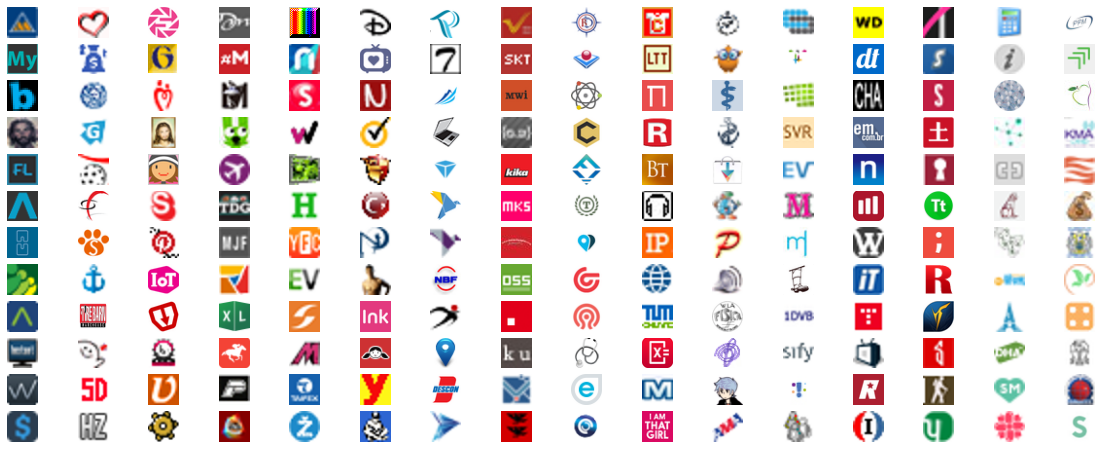

In [ ]:
from matplotlib import pyplot as plt
import h5py
import csv

NUM_CLUSTERS = 16
N_ROW = NUM_CLUSTERS
N_COL = 12

data_file_path = '/content/drive/Shared drives/DL Final Project/Code/Data/LLD-icon.hdf5'
cluster_file_path = f'/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/{NUM_CLUSTERS}_best_clusters_data.csv'

image_data = h5py.File(data_file_path, 'r')['data']
cluster_data = []
with open(cluster_file_path, 'r') as f:
    for row in csv.reader(f):
        cluster_data.append([int(float(v)) for v in row])
        #cluster_data.append(int(float(row[0])))

def getImage(image):
    return tf.cast(tf.transpose(image, [1, 2, 0]), tf.int32)

# cluster_list = [5, 19, 26, 27, 51, 60, 62, 0]
# cherry_picked_icon = [[1, 2, 7, 10, 12, 16, 20, 23],
#                       [6, 7, 8, 10, 12, 15, 16, 17],
#                       [0, 5, 10, 11, 24, 25, 26, 27],
#                       [0, 2, 6, 7, 9, 11, 12, 20],
#                       [2, 3, 4, 10, 19, 20, 28, 29],
#                       [1, 8, 12, 13, 14, 15, 20, 28],
#                       [0, 2, 5, 12, 15, 17, 20, 21],
#                       [0, 1, 2, 3, 11, 15, 16, 17]]

cluster_data = np.array(cluster_data)
fig = plt.figure(figsize=(20, 8))
for c in range(NUM_CLUSTERS):
    #idx = np.random.choice(np.where(cluster_data==c)[0], N_COL)
    idx = cluster_data[c]
    for r in range(N_COL):
        image = image_data[idx[r]]
        fig.add_subplot(N_COL, N_ROW, r*N_ROW+c+1)
        plt.imshow(getImage(image))
        plt.axis('off')

In [ ]:
from matplotlib import pyplot as plt
import h5py
import csv

NUM_CLUSTERS = 64
N_ROW = NUM_CLUSTERS
N_COL = 12

data_file_path = '/content/drive/Shared drives/DL Final Project/Code/Data/LLD-icon.hdf5'
cluster_file_path = f'/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/{NUM_CLUSTERS}_clusters_data.csv'

cluster_file_path_16 = f'/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/16_clusters_data.csv'

#image_data = h5py.File(data_file_path, 'r')['data']

cluster_data = []
count = np.zeros(NUM_CLUSTERS)
with open(cluster_file_path, 'r') as f:
    for row in csv.reader(f):
        #cluster_data.append([int(float(v)) for v in row])
        for i in range(NUM_CLUSTERS):
            if int(float(row[0])) == i:
                count[i] += 1

print(count)

cluster_data = []
count = np.zeros(16)
with open(cluster_file_path_16, 'r') as f:
    for row in csv.reader(f):
        #cluster_data.append([int(float(v)) for v in row])
        for i in range(16):
            if int(float(row[0])) == i:
                count[i] += 1
print(count)

[ 4872.  8557.  3956.  4775. 17856.  3901.  4214.  9035. 14339.  7055.
  9496.  3193.  3221.  9485.  5839.  7525.  3953.  6613.  9555.  4721.
  3297.  4119.  8385. 10128.  9091. 15476.  3513.  2078. 12174. 10157.
  4816. 12855. 15941. 11431. 14271.  6825. 11758. 10279.  4820.  4210.
  4517. 15363.  8528. 12247.  5716.  7382.  4108.  5014. 12903.  7847.
 16972.  4011.  3320.  5093.  8151.  7691.  9164.  7457.  3490.  3581.
  2614.  6898.  2222.  4303.]
[19529. 48127. 19052. 22749. 36904. 20336. 13908. 17018. 12646. 34148.
 34858. 59508. 17643. 12845. 55090. 62016.]
